In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [38]:
#%%
from matplotlib import pyplot
from math import cos, sin, atan


class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 10
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        pyplot.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        pyplot.figure(figsize=(16, 16))
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        pyplot.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

In [1]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Dataset and outline

### 1. Explain which regression problem you have chosen to solve.

As mentioned in the previous report, the data we will be using is a webscraping of movie data from imdb.com. In this report we will explore regression and try to predict what revenue (gross) a movie will generate, based on available numerical data. The first step is to create a baseline prediction using simple linear regression. After we have a baseline to compare with, we will create an Artificial Neural Network for regression, which may perform better than our linear model. Finally we will evaluate the linear model against the neural network to see which model gives the best prediction.



## Additional dataprocessing

As the dataset was created with automated webscraping and the author did not manually correct all the currencies, different countries use different currencies. Budget-values in different currencies, will misrepresent the movies actual budget cost, and cannot be used for training or testing our models. Since we are looking for misrepresentations in budget and gross, we should take a closer look at how values in these categories are distributed.

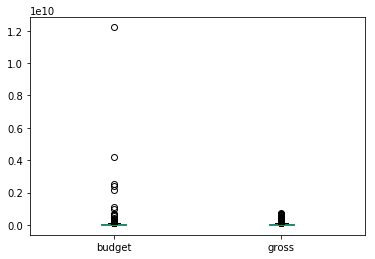

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
#figure_number = 0
data = pd.Series({})
data['raw'] = pd.read_csv("movie_metadata.csv")
data['raw'][['budget', 'gross']].plot(kind='box'); # too high values exist
#figure_number += 1
#print("Figure: {} - Boxplot for budget and gross".format(figure_number))

On the boxplot above, we can see that there are some extreme outliers in both gross and budget. These outliers are so far away from the remaining distribution, that it is impossible to get extract further information from the boxplot. It is therefore necessary to investigate why this happens, and if the outliers seem reasonable.

To further investigate our outliers, we check the top 15 values for both budget and gross. Apart from the budget and cost, it may be useful to know the movie's title and origin country.

In [3]:
budget_top15 = data['raw']['budget'].nlargest(15).keys()
print("Top 15 movies (budget)")
data['raw'].loc[budget_top15][['movie_title', 'country', 'budget', 'gross']]

Top 15 movies (budget)


,movie_title,country,budget,gross
2988,The Host,South Korea,1.221550e+10,2201412.0
3859,Lady Vengeance,South Korea,4.200000e+09,211667.0
3005,Fateless,Hungary,2.500000e+09,195888.0
2323,Princess Mononoke,Japan,2.400000e+09,2298191.0
2334,Steamboy,Japan,2.127520e+09,410388.0
3423,Akira,Japan,1.100000e+09,439162.0
4542,Godzilla 2000,Japan,1.000000e+09,10037390.0
3075,Kabhi Alvida Naa Kehna,India,7.000000e+08,3275443.0
3851,Tango,Spain,7.000000e+08,1687311.0
3273,Kites,India,6.000000e+08,1602466.0


In [4]:
gross_top15 = data['raw']['gross'].nlargest(15).keys()
print("Top 15 movies (gross)")
data['raw'].loc[gross_top15][['movie_title', 'country', 'budget', 'gross']]

Top 15 movies (gross)


,movie_title,country,budget,gross
0,Avatar,USA,237000000.0,760505847.0
26,Titanic,USA,200000000.0,658672302.0
29,Jurassic World,USA,150000000.0,652177271.0
17,The Avengers,USA,220000000.0,623279547.0
794,The Avengers,USA,220000000.0,623279547.0
66,The Dark Knight,USA,185000000.0,533316061.0
240,Star Wars: Episode I - The Phantom Menace,USA,115000000.0,474544677.0
3024,Star Wars: Episode IV - A New Hope,USA,11000000.0,460935665.0
8,Avengers: Age of Ultron,USA,250000000.0,458991599.0
3,The Dark Knight Rises,USA,250000000.0,448130642.0


Looking at the tables for top movies, in terms of budget and gross, we can see that budget outliers mainly come from countries where the local currency has substantially less value than USD (used for gross). Discovering this inconsistency in currency is important for the validity of our data. These entries need to be dropped from our dataset, or converted into USD. 

It is the opinion of the authors that reducing the amount of currencies to only USD would have been ideal, but an alternative is to only use US movies. Before doing this though, we should first check the number of movies per country, specifically the US, to ensure that there is enough entries to work with.

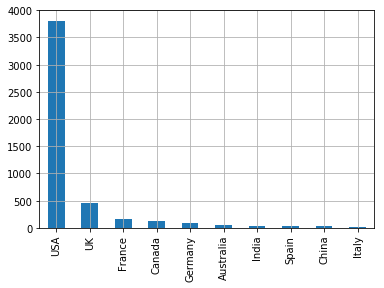

In [5]:
data['raw']['country'].value_counts().head(10).plot(kind='bar', grid=True); # Perhaps make it a cumsum plot

Looking at the top 10 movies-per-country we can see that the US contribute significantly to the dataset, with around 3800 movies, which is enough to work with.

We can now create a reduced version of our dataset with only movies from the US. We also remove NA's and features which are unreliable : "'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes',                                         'cast_total_facebook_likes', 'director_facebook_likes', 'movie_facebook_likes',                                        'aspect_ratio', 'facenumber_in_poster'". Lastly we create a numerical version of our dataset, which excludes categorical data, as well as a standardized version.

In [6]:
from sklearn.preprocessing import StandardScaler
data['reduced'] = data['raw'][data['raw']['country'] == 'USA']
data['reduced'] = data['reduced'].drop(['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 
                                        'cast_total_facebook_likes', 'director_facebook_likes', 'movie_facebook_likes',
                                        'aspect_ratio', 'facenumber_in_poster'], axis=1)
data['reduced'] = data['reduced'].dropna()
data['numerical'] = data['reduced'].select_dtypes(exclude=['object'])
data['standardized'] = StandardScaler().fit_transform(data['numerical'].values)
data['standardized'] = pd.DataFrame(data['standardized'], columns=data['numerical'].columns.values)
#data['standardized'].describe()

After creating a reduced dataset we need to create new tables and graphs to get an overview of our data.

In [7]:
budget_top15 = data['reduced']['budget'].nlargest(15).keys()
data['reduced'].loc[budget_top15][['movie_title', 'country', 'budget', 'gross']]

,movie_title,country,budget,gross
1,Pirates of the Caribbean: At World's End,USA,300000000.0,309404152.0
5,John Carter,USA,263700000.0,73058679.0
7,Tangled,USA,260000000.0,200807262.0
6,Spider-Man 3,USA,258000000.0,336530303.0
3461,Spider-Man 3,USA,258000000.0,336530303.0
3,The Dark Knight Rises,USA,250000000.0,448130642.0
8,Avengers: Age of Ultron,USA,250000000.0,458991599.0
10,Batman v Superman: Dawn of Justice,USA,250000000.0,330249062.0
18,Pirates of the Caribbean: On Stranger Tides,USA,250000000.0,241063875.0
27,Captain America: Civil War,USA,250000000.0,407197282.0


In [8]:
gross_top15 = data['reduced']['gross'].nlargest(15).keys()
data['reduced'].loc[gross_top15][['movie_title', 'country', 'budget', 'gross']]

,movie_title,country,budget,gross
0,Avatar,USA,237000000.0,760505847.0
26,Titanic,USA,200000000.0,658672302.0
29,Jurassic World,USA,150000000.0,652177271.0
17,The Avengers,USA,220000000.0,623279547.0
794,The Avengers,USA,220000000.0,623279547.0
66,The Dark Knight,USA,185000000.0,533316061.0
240,Star Wars: Episode I - The Phantom Menace,USA,115000000.0,474544677.0
3024,Star Wars: Episode IV - A New Hope,USA,11000000.0,460935665.0
8,Avengers: Age of Ultron,USA,250000000.0,458991599.0
3,The Dark Knight Rises,USA,250000000.0,448130642.0


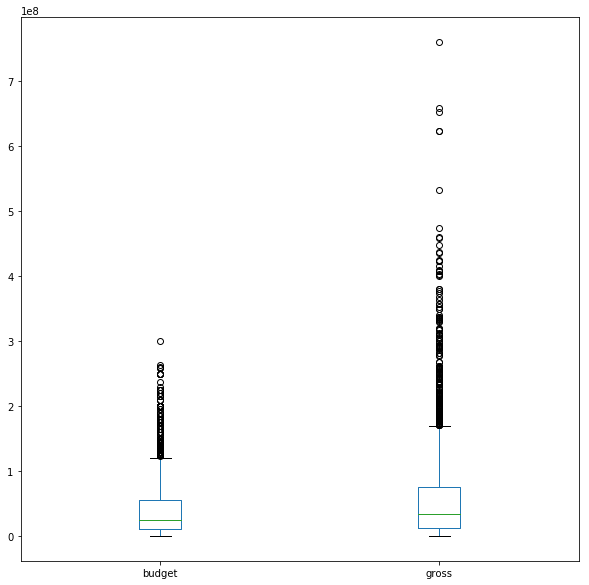

In [9]:
data['reduced'][['budget', 'gross']].plot(kind='box',figsize=(10,10));

From the above tables and graph we can see that the dataset has a more reasonable distribution and outliers in both budget and gross are roughly within a reasonable order of magnitude. It is expected that there will be outliers, but these should not be due to incorrect recording.

# Dataset splitting for regression

For our regression analysis we standardize our numerical data, and split our dataset into seperate training and test sets with a test-to-train ratio of 0.1.

In [10]:
from sklearn.model_selection import train_test_split

X = data['standardized'].drop('gross', axis=1)
y = data['standardized'][['gross']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## 2. Apply linear regression with forward selection and consider if transforming or combining attributes potentially may be useful. For linear regression, plotting the residual error vs. the attributes can give some insight into whether including a transformation of a variable can improve the model, i.e. potentially describe parts of the residuals.

Before creating our model, we want to check which features are the most significant. We can do this with forward selection. With this method of feature selection an unused feature, which gives the largest descrease in error, is added to the regression model. When there are no features left that descrease the error, or all features are allocated, the iteration is over. We will do forward selection for 10 iterations.

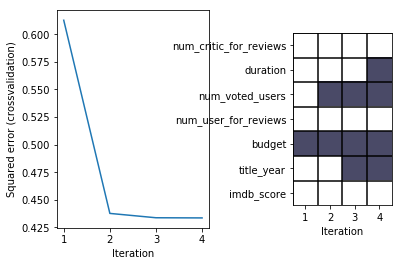

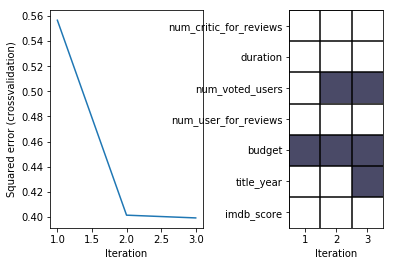

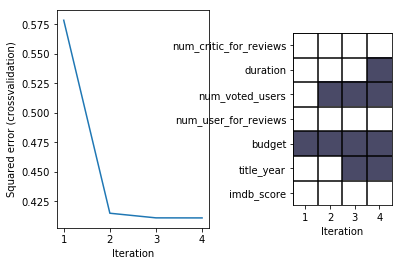

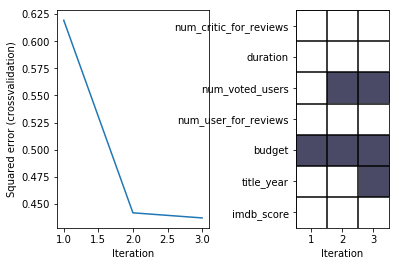

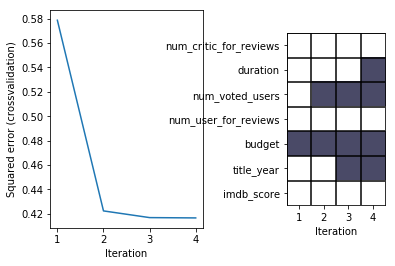

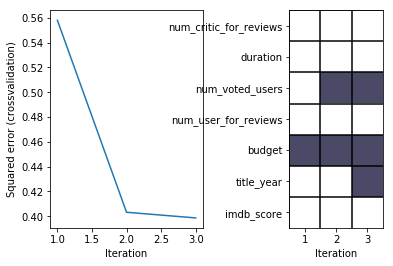

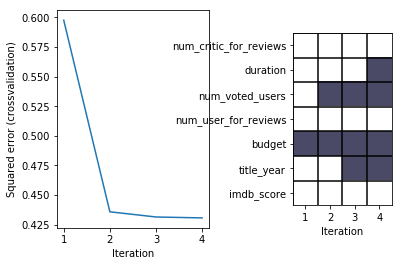

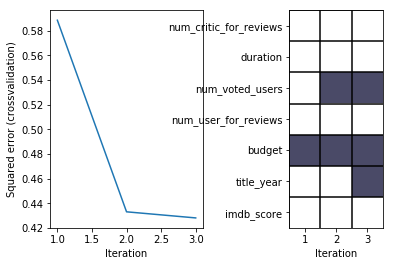

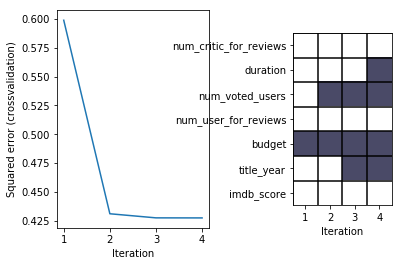

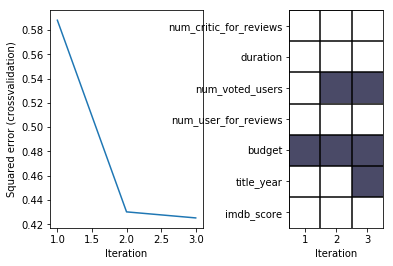

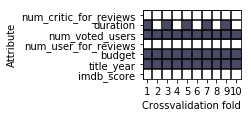

In [21]:
# exercise 6.2.1
from matplotlib.pyplot import figure, plot, subplot, title, xlabel, ylabel, show, clim
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import cross_validation
from toolbox_02450 import feature_selector_lr, bmplot
import numpy as np

# Load data from dataset
X = data['standardized'].drop('gross', axis=1)
y = data['standardized'][['gross']]

attributeNames = X.columns.values
N, M = X.shape


## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = cross_validation.KFold(N,K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
for train_index, test_index in CV:
    
    # extract training and test set for current CV fold
    X_train = X.values[train_index,:]
    y_train = y.values[train_index]
    X_test = X.values[test_index,:]
    y_test = y.values[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    #textout = 'verbose';
    textout = '';
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k]=1
    # .. alternatively you could use module sklearn.feature_selection
    if len(selected_features) is 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        clim(-1.5,0)
        xlabel('Iteration')
    '''
    print('Cross validation fold {0}/{1}'.format(k+1,K))
    print('Train indices: {0}'.format(train_index))
    print('Test indices: {0}'.format(test_index))
    print('Features no: {0}\n'.format(selected_features.size))
    ''';
    k+=1


# Display results
'''
print('\n')
print('Linear regression without feature selection:\n')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Linear regression with feature selection:\n')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))
''';
figure(k)
subplot(1,3,2)
bmplot(attributeNames, range(1,Features.shape[1]+1), -Features)
clim(-1.5,0)
xlabel('Crossvalidation fold')
ylabel('Attribute')


# Inspect selected feature coefficients effect on the entire dataset and
# plot the fitted model residual error as function of each attribute to
# inspect for systematic structure in the residual
'''
f=2 # cross-validation fold to inspect
ff=Features[:,f-1].nonzero()[0]
if len(ff) is 0:
    print('\nNo features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
else:
    m = lm.LinearRegression(fit_intercept=True).fit(X.values[:,ff], y)
    
    y_est= m.predict(X.values[:,ff])
    residual=y-y_est
    
    figure(k+1)
    title('Residual error vs. Attributes for features selected in cross-validation fold {0}'.format(f))
    for i in range(0,len(ff)):
       subplot(2,np.ceil(len(ff)/2.0),i+1)
       plot(X.values[:,ff[i]],residual,'.')
       xlabel(attributeNames[ff[i]])
       ylabel('residual error')
    
    
    show()    
''';

From the figures above we see that there is a sharp drop between first and second iterations, but a relatively flat line thereafter. In the crossvalidation graph we can deduce that a model with: 'title_year', 'budget', 'num_voted_users' and 'duration' yeilds the best result.

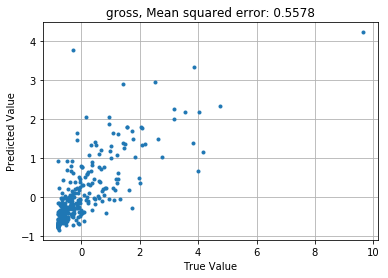

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = data['standardized'][['duration', 'num_voted_users', 'budget', 'title_year']]

#X = data['standardized'].drop('gross', axis=1)
y = data['standardized'][['gross']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
error = mean_squared_error(y_test, y_pred)

# Visualize prediction against true value
plt.figure()
plt.plot(y_test,y_pred,'.')
plt.grid()
plt.title('{0}, Mean squared error: {1:.04f}'.format(y_train.columns[0], error))
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.show()

With a mean squared error of 0.5578 our model isn't great at predicting, but hopefully we can create a better prediction with the neural network.

## 3. Explain how a new data observation is predicted according to the estimated model. I.e. what are the effects of the selected attributes in terms of predicting the data. (Notice, if you interpret the magnitude of the estimated coefficients this in general requires that each attribute be normalized prior to the analysis.).

The model is now able to predict the gross of a movie based on four features: 'title_year', 'budget', 'num_voted_users' and 'duration'. This prediction is calculated based on a bias called the intercept, and one scalar weight for each feature. To get a better overview of exactly how much each feature contributes, we can show the weights in a table and a graph.

title_year       :	-0.0481181217394054
budget           :	0.45616615234074775
num_voted_users  :	0.49017499697535283
duration         :	-0.08764284472047591


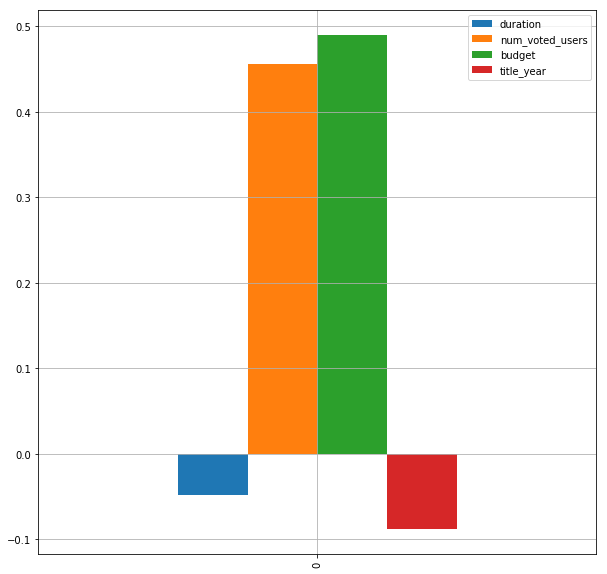

In [23]:
for feature in zip(['title_year', 'budget', 'num_voted_users', 'duration'], lm.coef_[0]):
    print("{:17}:\t{}".format(feature[0], feature[1]))
pd.DataFrame(lm.coef_, columns=X.columns.values.tolist()).plot.bar(grid=True, figsize=(10,10));

From the above graph and table we can see that some features contribute significantly less than others. It is of course always possible a better model exists, but according to our feature selection, this is the best model we can make with the features available.

In [24]:
for n in [0, 1, 2]:
    print("[{}] Prediction: {}\tTrue: {}\tDifference: {}"
          .format(n, y_pred[n], y_test.values[n], y_pred[n]-y_test.values[n]))

[0] Prediction: [-0.04422528]	True: [ 0.95920179]	Difference: [-1.00342707]
[1] Prediction: [ 0.91823521]	True: [-0.31600123]	Difference: [ 1.23423644]
[2] Prediction: [ 0.39966987]	True: [-0.04010525]	Difference: [ 0.43977512]


## 4. Fit an artificial neural network (ANN) model to the data.

With a baseline prediction established, we can move on to creating a neural network model. We want a model with multiple layers and a single output node.

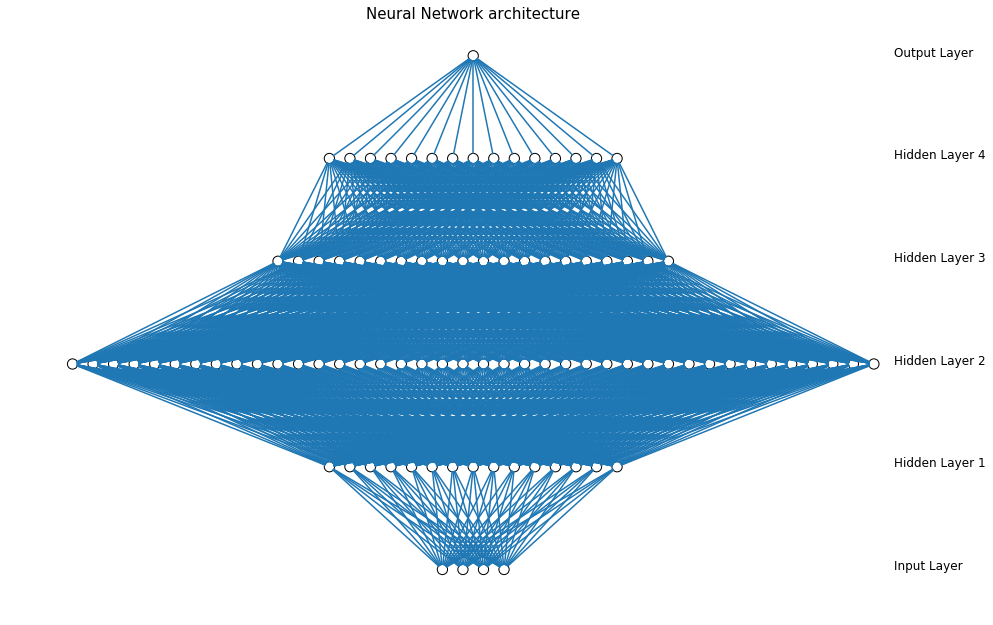

Mean squared error: 0.38344145067349145


In [33]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

# Feature selection
X = data['standardized'][['duration', 'num_voted_users', 'budget', 'title_year']]
y = data['standardized'][['gross']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
shape = X.shape[1]
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model = Sequential()
model.add(Dense(15, input_shape=(shape,), activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[])
history = model.fit(X_train.values, y_train.values, epochs = 30, batch_size=500, shuffle=False, verbose=0)
y_pred = model.predict(X_test.values, batch_size = 1000)
error = mean_squared_error(y_test, y_pred)
network = DrawNN([shape, 15, 40,20, 15, 1])
network.draw()
print("Mean squared error: {}".format(error))

We can see that the neural network has a lower error rate than our linear model, thus an increase in model performance can be achieved by using a neural network instead of a linear classifier. Additional performance might be possible, with another configuration than the current illustrated above.

## 5. Statistically evaluate if there is a significant performance difference between the fitted ANN and linear regression models based on the same cross-validation splits (i.e., considering the credibility interval equivalent to the use of a paired t-test as described in lecture 6 and last exercise week 6). Compare in addition if the performance of your models are better than simply predicting the output to be the average of the training data output. 

To evaluate our two models we want to run them against each other on the same training set and see which model performs best. Since the weights in the neural network models are initiated with random values we should do more than a single round. If we perform a comparisson 200 times, we should be able to estimate how the model will perform compared to the baseline linear prediction.

In [27]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Feature selection
X = data['standardized'][['num_critic_for_reviews', 'duration', 'num_voted_users',
                       'num_user_for_reviews', 'budget', 'title_year', 'imdb_score']]

X = data['standardized'][['duration', 'num_voted_users', 'budget', 'title_year']]
y = data['standardized'][['gross']]

lm = LinearRegression()

shape = X.shape[1]
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

scores = []

for n in range(200):
    if (n % 1 == 0):
        print(n)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    lm.fit(X_train, y_train)
    lm_y_pred = lm.predict(X_test)
    lm_error = mean_squared_error(y_test, lm_y_pred)
    
    model = Sequential()
    model.add(Dense(15, input_shape=(shape,), activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=[])
    history = model.fit(X_train.values, y_train.values, epochs=300, batch_size=500, shuffle=False, verbose=0)
    ann_y_pred = model.predict(X_test.values, batch_size = 1000)
    ann_error = mean_squared_error(y_test, ann_y_pred)
    #print("[{}] LinearModel: {}\tANN: {}".format(n, lm_error, ann_error))
    scores.append([lm_error, ann_error])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92


KeyboardInterrupt: 

From the histogram we can see that the neural network has a better performance than our linear model. On some occasions it performs worse, but most of the time there is an increase in performance.

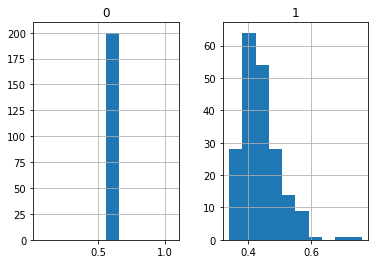

In [97]:
pd.DataFrame(newscores).hist();

From the histogram we can see that the neural network has a better performance than our linear model. On some occasions it performs worse, but most of the time there seems to be an increase in performance. To check this we can use a t-test and compare the errors from both models.

CV-fold 1 of 20
CV-fold 2 of 20
CV-fold 3 of 20
CV-fold 4 of 20
CV-fold 5 of 20
CV-fold 6 of 20
CV-fold 7 of 20
CV-fold 8 of 20
CV-fold 9 of 20
CV-fold 10 of 20
CV-fold 11 of 20
CV-fold 12 of 20
CV-fold 13 of 20
CV-fold 14 of 20
CV-fold 15 of 20
CV-fold 16 of 20
CV-fold 17 of 20
CV-fold 18 of 20
CV-fold 19 of 20
CV-fold 20 of 20
Classifiers are significantly different.


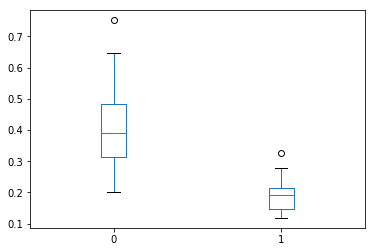

In [114]:
# exercise 6.3.1
from matplotlib.pyplot import figure, boxplot, xlabel, ylabel, show
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import cross_validation, tree
from scipy import stats

X = data['standardized'][['duration', 'num_voted_users', 'budget', 'title_year']].values
y = data['standardized'][['gross']].values
N, M = X.shape

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 20
CV = cross_validation.KFold(N,K,shuffle=True)
#CV = cross_validation.StratifiedKFold(y.A.ravel(),k=K)

# Initialize variables
Error_lm = np.empty((K,1))
Error_ann = np.empty((K,1))

n_tested=0

k=0
for train_index, test_index in CV:
    
    print('CV-fold {0} of {1}'.format(k+1,K))
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]

    # Fit and evaluate Logistic Regression classifier
    #model = lm.logistic.LogisticRegression(C=N)
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_lm = lm.predict(X_test)
    #print(y_lm)
    #Error_lm[k] = 100*(y_lm!=y_test).sum().astype(float)/len(y_test)
    #print(Error_lm)
    
    # Fit and evaluate Decision Tree classifier
    #model2 = tree.DecisionTreeClassifier()
    model.fit(X_train, y_train, epochs=60, batch_size=500, shuffle=False, verbose=0)
    y_ann = model.predict(X_test)
    #Error_ann[k] = 100*(y_ann!=y_test).sum().astype(float)/len(y_test)
    Error_lm[k] = mean_squared_error(y_test, y_lm)
    Error_ann[k] = mean_squared_error(y_test, y_ann)
    
    k+=1
    

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 


#z = (Error_lm-Error_ann)
z = (lm_error - ann_error)
#zb = z.mean()
zb = np.mean(z)
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Classifiers are not significantly different')        
else:
    print('Classifiers are significantly different.')
    
# Boxplot to compare classifier error distributions
pd.DataFrame(np.array([Error_lm.flatten(),Error_ann.flatten()]).T).plot.box();

By statistically comparing the two classifiers with a t-test we can conclude that the models are indeed significantly different. This means that for our dataset, the neural network is better at predicting movie gross, based only on four features.